In [1]:
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt
import numpy as np

import sklearn
import sklearn.metrics
import matplotlib
import scipy
import mplhep

import pandas

In [2]:
def flatten(arr):
    return arr.reshape((arr.shape[0]*arr.shape[1], arr.shape[2]))

In [3]:
def cms_label(x0=0.12, x1=0.23, x2=0.67, y=0.90):
    plt.figtext(x0, y,'CMS',fontweight='bold', wrap=True, horizontalalignment='left', fontsize=12)
    plt.figtext(x1, y,'Simulation Preliminary', style='italic', wrap=True, horizontalalignment='left', fontsize=10)
    plt.figtext(x2, y,'Run 3 (14 TeV), $\mathrm{t}\overline{\mathrm{t}}$ events',  wrap=False, horizontalalignment='left', fontsize=10)

def sample_label(ax, x=0.03, y=0.98):
    plt.text(x, y, "$\mathrm{t}\overline{\mathrm{t}}$ events", va="top", ha="left", size=10, transform=ax.transAxes)


In [4]:
def apply_thresholds_f(ypred_raw_f, thresholds):
    msk = np.ones_like(ypred_raw_f)
    for i in range(len(thresholds)):
        msk[:, i+1] = ypred_raw_f[:, i+1]>thresholds[i]
    ypred_id_f = np.argmax(ypred_raw_f*msk, axis=-1)
    
#     best_2 = np.partition(ypred_raw_f, -2, axis=-1)[..., -2:]
#     diff = np.abs(best_2[:, -1] - best_2[:, -2])
#     ypred_id_f[diff<0.05] = 0
    
    return ypred_id_f

def apply_thresholds(ypred_raw, thresholds):
    msk = np.ones_like(ypred_raw)
    for i in range(len(thresholds)):
        msk[:, :, i+1] = ypred_raw[:, :, i+1]>thresholds[i]
    ypred_id = np.argmax(ypred_raw*msk, axis=-1)
    
#     best_2 = np.partition(ypred_raw, -2, axis=-1)[..., -2:]
#     diff = np.abs(best_2[:, :, -1] - best_2[:, :, -2])
#     ypred_id[diff<0.05] = 0
    
    return ypred_id

In [5]:
CMS_PF_CLASS_NAMES = ["none" "charged hadron", "neutral hadron", "hfem", "hfhad", "photon", "electron", "muon"]

ELEM_LABELS_CMS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ELEM_NAMES_CMS = ["NONE", "TRACK", "PS1", "PS2", "ECAL", "HCAL", "GSF", "BREM", "HFEM", "HFHAD", "SC", "HO"]

CLASS_LABELS_CMS = [0, 211, 130, 1, 2, 22, 11, 13]
CLASS_NAMES_CMS = ["none", "ch.had", "n.had", "HFEM", "HFHAD", "gamma", "ele", "mu"]

In [6]:
path = "../experiments/cms_20210907_154903_224727.joosep-desktop-work/evaluation/"

In [7]:
Xs = []
yvals = {}
for fi in list(glob.glob(path + "/pred_batch*.npz")):
    dd = np.load(fi)
    Xs.append(dd["X"])
    
    keys_in_file = list(dd.keys())
    for k in keys_in_file:
        if k=="X":
            continue
        if not (k in yvals):
            yvals[k] = []
        yvals[k].append(dd[k])

X = np.concatenate(Xs)
X_f = flatten(X)

msk_X_f = X_f[:, 0] != 0

yvals = {k: np.concatenate(v) for k, v in yvals.items()}
yvals["true_phi"] = np.arctan2(yvals["true_sin_phi"], yvals["true_cos_phi"])
yvals["pred_phi"] = np.arctan2(yvals["pred_sin_phi"], yvals["pred_cos_phi"])

yvals_f = {k: flatten(v) for k, v in yvals.items()}

yvals["true_cls_id"] = np.argmax(yvals["true_cls"], axis=-1)
yvals["pred_cls_id"] = np.argmax(yvals["pred_cls"], axis=-1)
yvals_f["true_cls_id"] = np.argmax(yvals_f["true_cls"], axis=-1)
yvals_f["pred_cls_id"] = np.argmax(yvals_f["pred_cls"], axis=-1)

In [8]:
def plot_distribution(yptcl_f, bins, var_idx, particle_label, labels):

    hists = []
    for icls in range(1,8):
        msk_pid = (yptcl_f[:, 0]==icls)
        h = np.histogram(yptcl_f[msk_pid, var_idx], bins=bins)
        hists.append(h)
        
    plt.figure(figsize=(5,5))
    ax = plt.axes()
    
    mplhep.histplot(
        [h[0] for h in hists], bins=hists[0][1], ax=ax, stack=True, histtype="fill",
        label=labels
    )
    plt.legend(ncol=2, frameon=False)
    plt.xlabel(var_names[var_idx])
    cms_label(x1=0.22, x2=0.55)
    plt.ylabel("Number of particles / bin")
    plt.text(0.02, 0.95, particle_label, transform=ax.transAxes)
    return ax

In [9]:
def delta_phi(a,b):
    return (a - b + np.pi) % (2 * np.pi) - np.pi

In [10]:
def plot_eta_phi_residual(ielem):
    msk1 = (X_f[:, 0]==ielem) & (ycand_f[:, 0]!=0)
    msk2 = (X_f[:, 0]==ielem) & (ygen_f[:, 0]!=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*4, 4))
    
    bins = np.linspace(-10, 10, 61)
    plt.sca(ax1)
    plt.hist(X_f[msk1, 2] - ycand_f[msk1, 3], bins=bins, histtype="step", lw=2, label="PF");
    plt.hist(X_f[msk2, 2] - ygen_f[msk2, 3], bins=bins, histtype="step", lw=2, label="MC");
    plt.legend(frameon=False)
    plt.yscale("log")
    plt.xlabel("$\Delta\eta(\mathrm{PFElement}, \mathrm{particle})$")
    plt.sca(ax2)
    
    bins = np.linspace(-4, 4, 61)
    plt.hist(delta_phi(X_f[msk1, 3], np.arctan2(ycand_f[msk1, 4], ycand_f[msk1, 5])), bins=bins, histtype="step", lw=2, label="PF");
    plt.hist(delta_phi(X_f[msk2, 3], np.arctan2(ygen_f[msk2, 4], ygen_f[msk2, 5])), bins=bins, histtype="step", lw=2, label="MC");
    plt.legend(frameon=False)
    plt.xlabel("$\Delta\phi(\mathrm{PFElement}, \mathrm{particle})$")

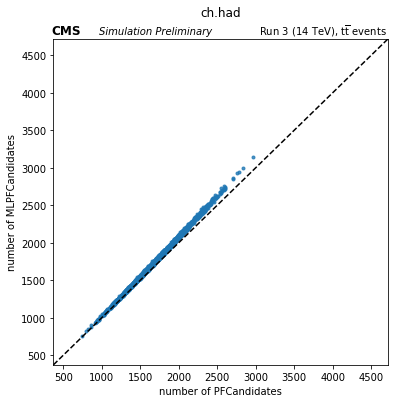

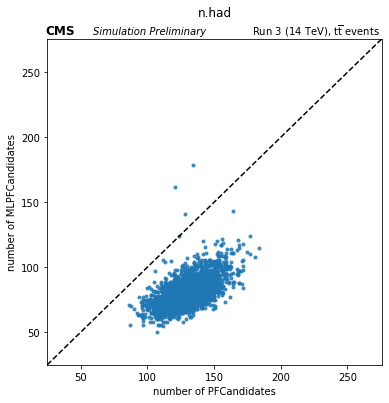

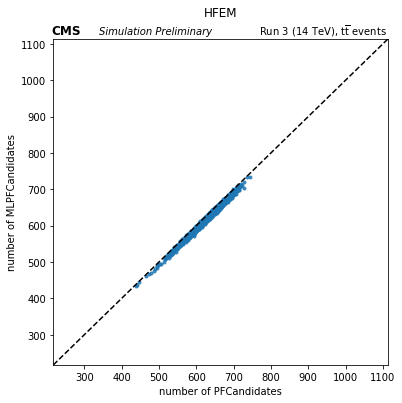

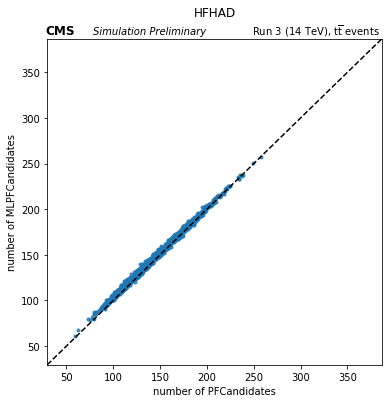

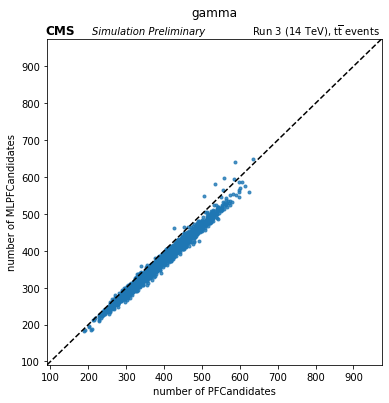

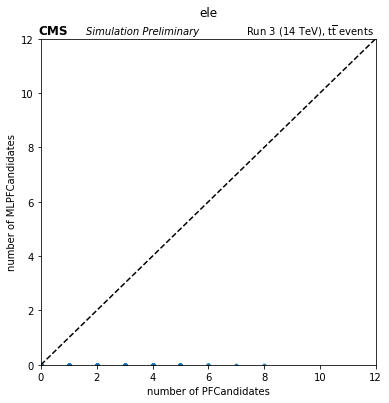

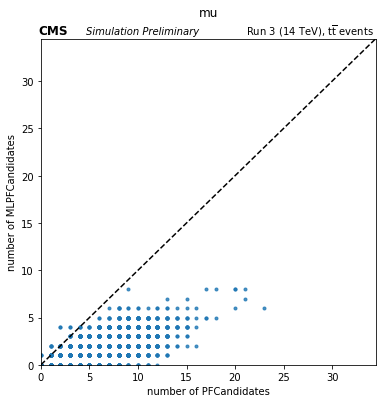

In [11]:
for icls in range(1,8):
    npred = np.sum(yvals["pred_cls_id"] == icls, axis=1)
    ncand = np.sum(yvals["true_cls_id"] == icls, axis=1)
    plt.figure(figsize=(6,6))
    plt.scatter(ncand, npred, marker=".", alpha=0.8)
    a = 0.5*min(np.min(npred), np.min(ncand))
    b = 1.5*max(np.max(npred), np.max(ncand))
    plt.xlim(a,b)
    plt.ylim(a,b)
    plt.plot([a,b],[a,b], color="black", ls="--")
    plt.title(CLASS_NAMES_CMS[icls],y=1.05)
    plt.xlabel("number of PFCandidates")
    plt.ylabel("number of MLPFCandidates")
    cms_label(x2=0.6, y=0.89)
    plt.savefig("num_cls{}.pdf".format(icls))


In [12]:
elem_type = 5
icls = 2

def plot_elem_energy_cls_prob(elem_type):
    plt.figure(figsize=(4*5,2*4))
    plt.suptitle("PFElement type {}".format(elem_type))
    
    for icls in range(8):
        plt.subplot(2,4,icls+1)
        plt.hist2d(
            np.log10(X_f[X_f[:, 0]==elem_type, 4]),
            ypred_raw_f[X_f[:, 0]==elem_type, icls],
            bins=(np.linspace(-2,4,100), np.linspace(0,1,100)), cmap="Blues");
        plt.colorbar()
        plt.xlabel("PFElement log[E/GeV]")
        plt.ylabel("MLPF probability for class {}".format(icls))
    plt.tight_layout()

In [13]:
def plot_eff_and_fake_rate(
    icls,
    ivar=4,
    bins=np.linspace(-3,6,100),
    xlabel="PFElement log[E/GeV]", log=True
    ):
    
    values = X_f[:, ivar]
    if log:
        values = np.log(values)
        
    hist_cand = np.histogram(values[(yvals_f["true_cls_id"]==icls)], bins=bins);
    hist_cand_true = np.histogram(values[(yvals_f["true_cls_id"]==icls) & (yvals_f["pred_cls_id"]==icls)], bins=bins);

    hist_pred = np.histogram(values[(yvals_f["pred_cls_id"]==icls)], bins=bins);
    hist_pred_fake = np.histogram(values[(yvals_f["true_cls_id"]!=icls) & (yvals_f["pred_cls_id"]==icls)], bins=bins);

    eff = hist_cand_true[0]/hist_cand[0]
    fake = hist_pred_fake[0]/hist_pred[0]

    plt.figure(figsize=(8,8))
    ax1 = plt.subplot(2,1,1)
    mplhep.histplot(hist_cand, label="with PF candidate")
    mplhep.histplot(hist_pred, label="with MLPF candidate")
    plt.legend(frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel("Number of particles")

    ax2 = plt.subplot(2,1,2, sharex=ax1)
    mplhep.histplot(eff, bins=hist_cand[1], label="efficiency", color="black")
    mplhep.histplot(fake, bins=hist_cand[1], label="fake rate", color="red")
    plt.legend(frameon=False)
    plt.ylim(0,1.4)
    plt.xlabel(xlabel)
    plt.ylabel("Fraction of particles / bin")
    
    return ax1, ax2

/tmp/ipykernel_529227/434032650.py:18: RuntimeWarning: invalid value encountered in true_divide
  eff = hist_cand_true[0]/hist_cand[0]
/tmp/ipykernel_529227/434032650.py:19: RuntimeWarning: invalid value encountered in true_divide
  fake = hist_pred_fake[0]/hist_pred[0]


Text(0.5, 1.0, 'track, charged hadron predictions')

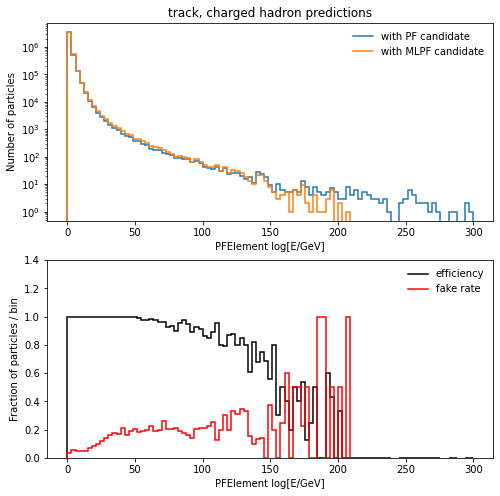

In [14]:
ax1, ax2 = plot_eff_and_fake_rate(1, bins=np.linspace(0, 300, 100), log=False)
ax1.set_yscale("log")
ax1.set_title("track, charged hadron predictions")

Text(0.5, 1.0, 'HCAL cluster, neutral hadron predictions')

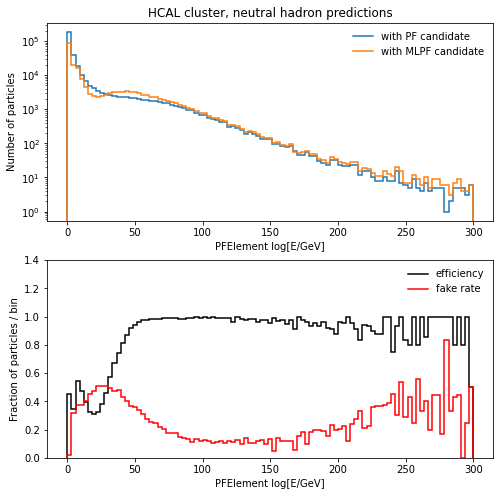

In [15]:
ax1, ax2 = plot_eff_and_fake_rate(2, bins=np.linspace(0, 300, 100), log=False)
ax1.set_yscale("log")
ax1.set_title("HCAL cluster, neutral hadron predictions")

/tmp/ipykernel_529227/434032650.py:18: RuntimeWarning: invalid value encountered in true_divide
  eff = hist_cand_true[0]/hist_cand[0]
/tmp/ipykernel_529227/434032650.py:19: RuntimeWarning: invalid value encountered in true_divide
  fake = hist_pred_fake[0]/hist_pred[0]


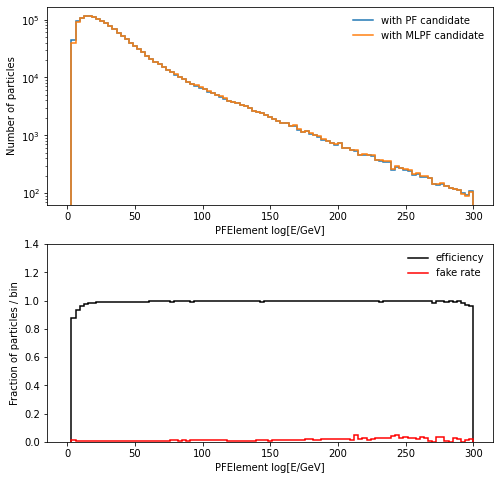

In [16]:
ax1, ax2 = plot_eff_and_fake_rate(3, bins=np.linspace(0, 300, 100), log=False)
ax1.set_yscale("log")

/tmp/ipykernel_529227/434032650.py:18: RuntimeWarning: invalid value encountered in true_divide
  eff = hist_cand_true[0]/hist_cand[0]
/tmp/ipykernel_529227/434032650.py:19: RuntimeWarning: invalid value encountered in true_divide
  fake = hist_pred_fake[0]/hist_pred[0]


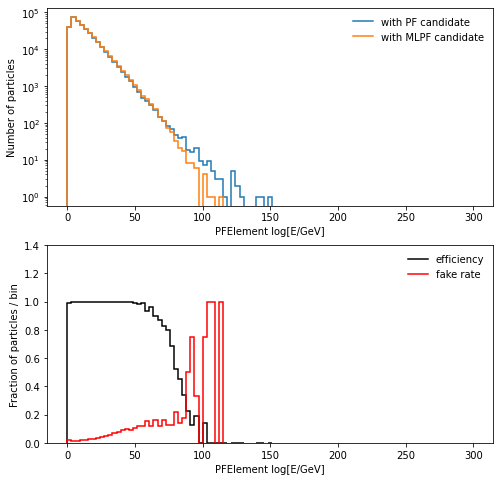

In [17]:
ax1, ax2 = plot_eff_and_fake_rate(4, bins=np.linspace(0, 300, 100), log=False)
ax1.set_yscale("log")

In [18]:
def load_history(path, max_epoch=None):
    ret = {}
    for fi in glob.glob(path):
        data = json.load(open(fi))
        epoch = int(fi.split("_")[-1].split(".")[0])
        ret[epoch] = data
    
    if not max_epoch:
        max_epoch = max(ret.keys())
    ret2 = []
    for i in range(1, max_epoch+1):
        ret2.append(ret[i])
    return pandas.DataFrame(ret2)

In [19]:
history = load_history(path + "/../history/history_*.json")

In [20]:
def loss_plot(train, test, margin=0.05, smoothing=False):
    fig = plt.figure(figsize=(8,4))
    ax = plt.axes()
    
    alpha = 0.2 if smoothing else 1.0
    l0 = None if smoothing else "train"
    l1 = None if smoothing else "test"
    p0 = plt.plot(train, alpha=alpha, label=l0)
    p1 = plt.plot(test, alpha=alpha, label=l1)
    
    if smoothing:
        train_smooth = np.convolve(train, np.ones(5)/5, mode='valid')
        plt.plot(train_smooth, color=p0[0].get_color(), lw=2, label="train")
        test_smooth = np.convolve(test, np.ones(5)/5, mode='valid')
        plt.plot(test_smooth, color=p1[0].get_color(), lw=2, label="test")
    
    plt.ylim(test[-1]*(1.0-margin), test[-1]*(1.0+margin))
    plt.legend(loc="best", frameon=False)
    plt.xlabel("epoch")
    cms_label(x1=0.18)

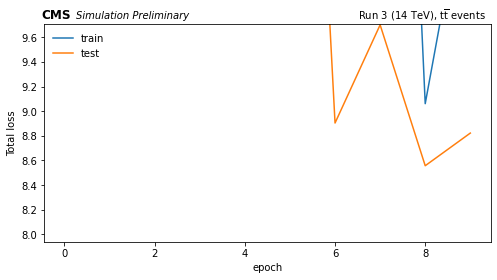

In [21]:
p0 = loss_plot(history["loss"].values, history["val_loss"].values, margin=0.1)
plt.ylabel("Total loss")
plt.savefig("loss.pdf", bbox_inches="tight")

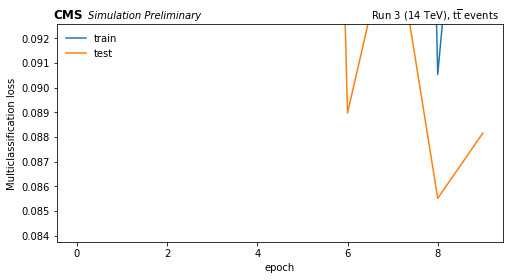

In [22]:
p0 = loss_plot(history["cls_loss"].values, history["val_cls_loss"].values, margin=0.05)
plt.ylabel("Multiclassification loss")
plt.savefig("cls_loss.pdf", bbox_inches="tight")

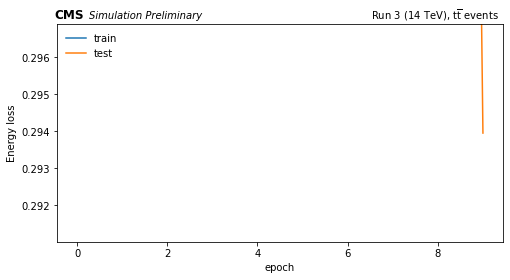

In [23]:
p0 = loss_plot(history["energy_loss"].values, history["val_energy_loss"].values, margin=0.01)
plt.ylabel("Energy loss")
plt.savefig("energy_loss.pdf", bbox_inches="tight")

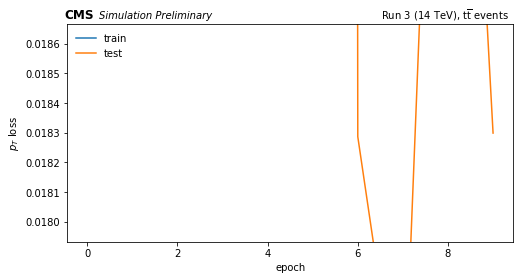

In [24]:
p0 = loss_plot(history["pt_loss"].values, history["val_pt_loss"].values, margin=0.02)
plt.ylabel("$p_T$ loss")
plt.savefig("pt_loss.pdf", bbox_inches="tight")

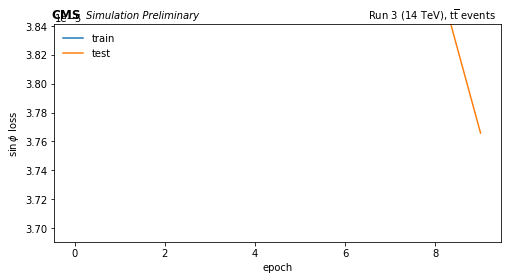

In [25]:
p0 = loss_plot(history["sin_phi_loss"].values, history["val_sin_phi_loss"].values, margin=0.02)
plt.ylabel("$\sin \phi$ loss")
plt.savefig("sin_phi_loss.pdf", bbox_inches="tight")

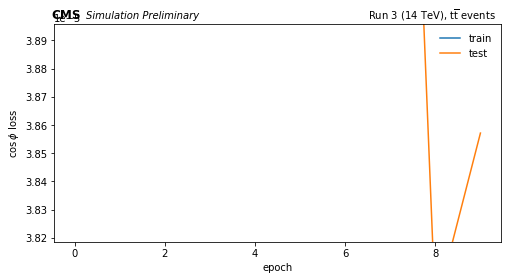

In [26]:
p0 = loss_plot(history["cos_phi_loss"].values, history["val_cos_phi_loss"].values, margin=0.01)
plt.ylabel("$\cos \phi$ loss")
plt.savefig("cos_phi_loss.pdf", bbox_inches="tight")

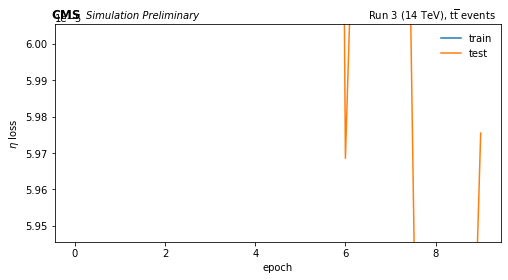

In [27]:
p0 = loss_plot(history["eta_loss"].values, history["val_eta_loss"].values, margin=0.005)
plt.ylabel("$\eta$ loss")
plt.savefig("eta_loss.pdf", bbox_inches="tight")

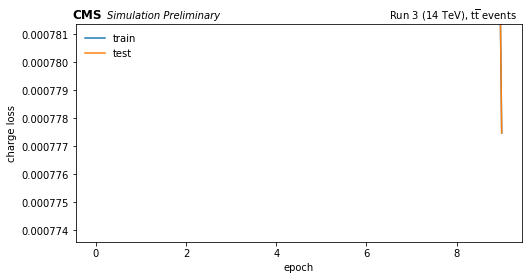

In [28]:
p0 = loss_plot(history["charge_loss"].values, history["charge_loss"].values, margin=0.005)
plt.ylabel("charge loss")
plt.savefig("charge_loss.pdf", bbox_inches="tight")

In [29]:
#perm = np.random.permutation(ycand_f[msk_X].shape[0])[:100000]

cm_norm = sklearn.metrics.confusion_matrix(
    yvals_f["true_cls_id"][msk_X_f],
    yvals_f["pred_cls_id"][msk_X_f],
    labels=range(0,8),
    normalize="true"
)

cm = sklearn.metrics.confusion_matrix(
    yvals_f["true_cls_id"][msk_X_f],
    yvals_f["pred_cls_id"][msk_X_f],
    labels=range(0,8),
)

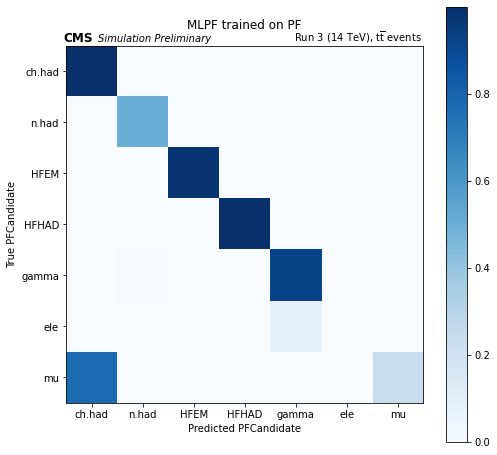

In [30]:
plt.figure(figsize=(8, 8))
ax = plt.axes()
plt.imshow(cm_norm[1:, 1:], cmap="Blues")
plt.colorbar()

cms_label(x1=0.18, x2=0.52, y=0.82)
plt.xticks(range(len(CLASS_NAMES_CMS)-1), CLASS_NAMES_CMS[1:]);
plt.yticks(range(len(CLASS_NAMES_CMS)-1), CLASS_NAMES_CMS[1:]);
plt.xlabel("Predicted PFCandidate")
plt.ylabel("True PFCandidate")
plt.title("MLPF trained on PF", y=1.03)
plt.savefig("cm_normed.pdf", bbox_inches="tight")

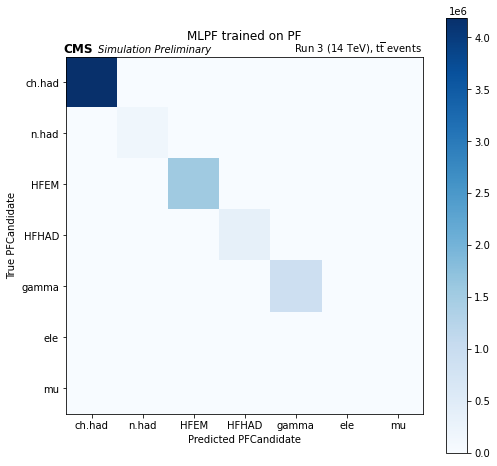

In [31]:
plt.figure(figsize=(8, 8))
ax = plt.axes()
plt.imshow(cm[1:, 1:], cmap="Blues")
plt.colorbar()

cms_label(x1=0.18, x2=0.52, y=0.82)
#sample_label(ax, x=0.8, y=1.0)
plt.xticks(range(len(CLASS_NAMES_CMS)-1), CLASS_NAMES_CMS[1:]);
plt.yticks(range(len(CLASS_NAMES_CMS)-1), CLASS_NAMES_CMS[1:]);
plt.xlabel("Predicted PFCandidate")
plt.ylabel("True PFCandidate")
plt.title("MLPF trained on PF", y=1.03)
plt.savefig("cm.pdf", bbox_inches="tight")

/tmp/ipykernel_529227/437186068.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


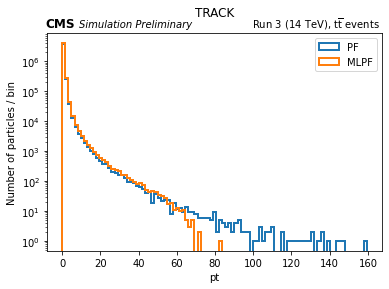

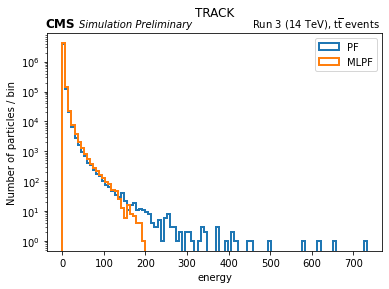

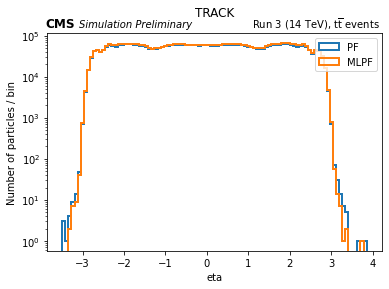

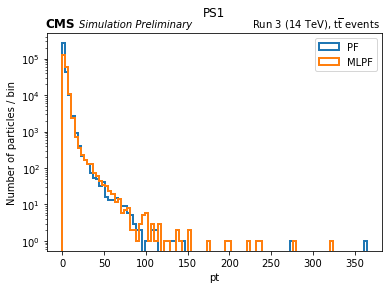

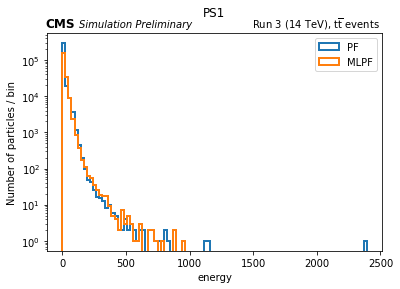

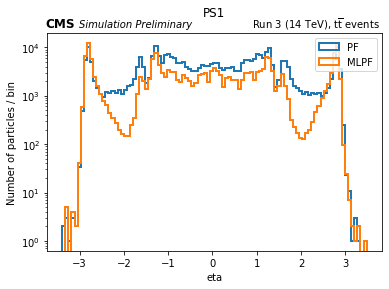

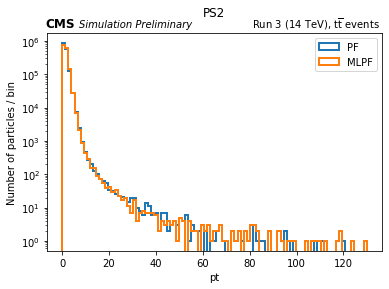

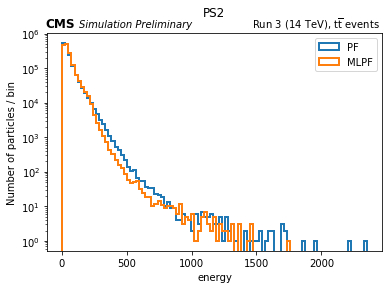

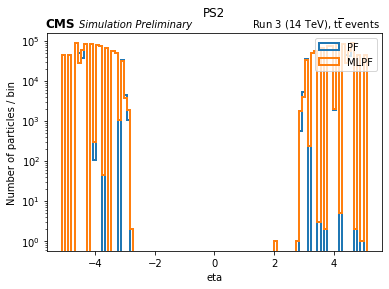

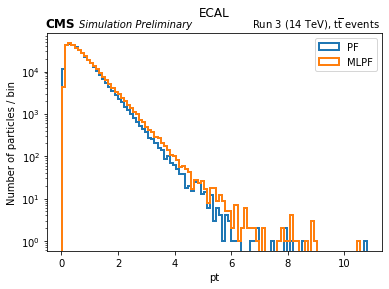

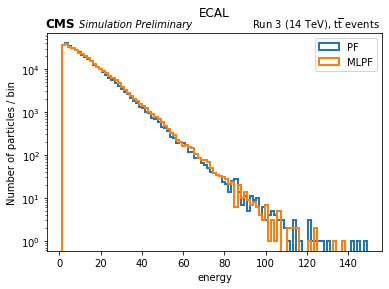

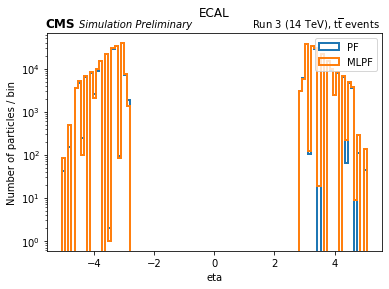

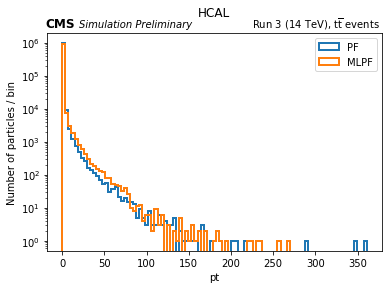

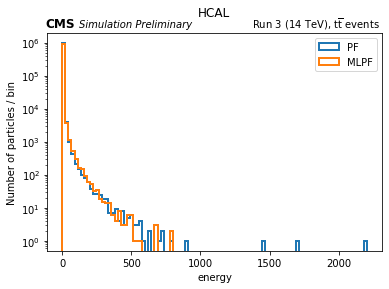

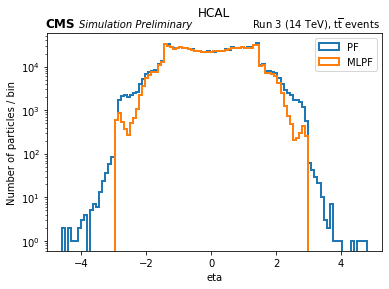

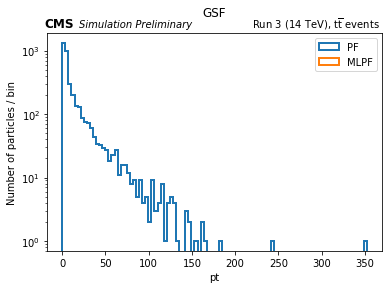

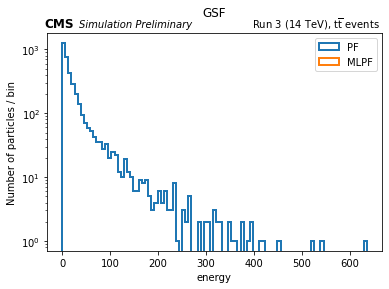

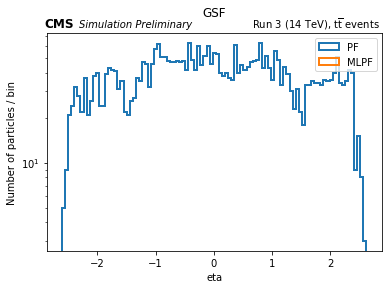

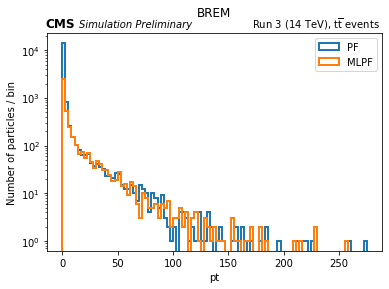

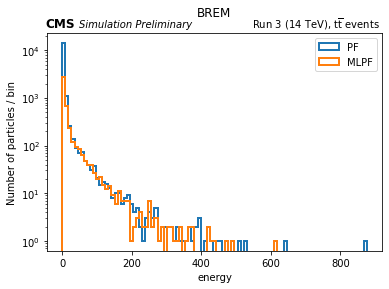

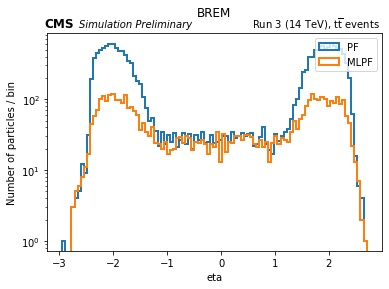

In [33]:
for icls in range(1,8):
    for ivar in ["pt", "energy", "eta"]:
        plt.figure()
        ax = plt.axes()
        
        vals_true = yvals_f["true_" + ivar][yvals_f["true_cls_id"]==icls]
        vals_pred = yvals_f["pred_" + ivar][yvals_f["pred_cls_id"]==icls]
        b = np.linspace(np.min(vals_true), np.max(vals_true), 100)

        plt.hist(vals_true, bins=b, histtype="step", lw=2, label="PF");
        plt.hist(vals_pred, bins=b, histtype="step", lw=2, label="MLPF");
        plt.yscale("log")
        plt.legend()
        plt.title(ELEM_NAMES_CMS[icls], y=1.05)
        plt.xlabel(ivar)
        plt.ylabel("Number of particles / bin")
        cms_label(x1=0.2, x2=0.6)
        plt.savefig("distribution_icls{}_{}.pdf".format(icls, ivar))

In [34]:
def plot_particle_regression(
    ivar="energy", icls=2,
    particle_label="Neutral hadrons",
    log=True,
    minval=-1,
    maxval=3,
    norm=matplotlib.colors.LogNorm()):
    
    plt.figure(figsize=(6,5))
    ax = plt.axes()
    
    bins = np.linspace(minval, maxval, 100)
    msk_both = (yvals_f["pred_cls_id"] == icls) & (yvals_f["true_cls_id"]==icls)
    
    vals_true = yvals_f["true_"+ivar][msk_both, 0]
    vals_pred = yvals_f["pred_"+ivar][msk_both, 0]
    
    if log:
        vals_true = np.log10(vals_true)
        vals_pred = np.log10(vals_pred)
    
    plt.hist2d(
        vals_true,
        vals_pred,
        bins=(bins, bins),
        cmap="Blues", norm=norm
    )
    
    plt.colorbar()
    plt.plot([minval, maxval], [minval, maxval], color="black", ls="--", lw=0.5)
    plt.xlim(minval, maxval)
    plt.ylim(minval, maxval)
    cms_label(x1=0.2, x2=0.48)
    plt.text(0.02, 0.95, particle_label, transform=ax.transAxes)
    ax.set_xticks(ax.get_yticks());

/tmp/ipykernel_529227/24793058.py:20: RuntimeWarning: invalid value encountered in log10
  vals_pred = np.log10(vals_pred)


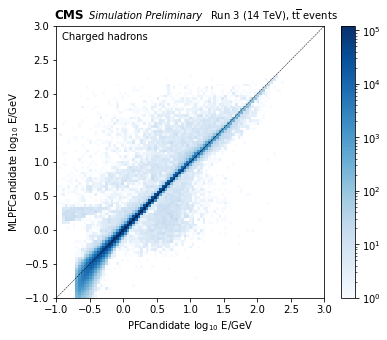

In [35]:
plot_particle_regression(ivar="energy", icls=1, particle_label="Charged hadrons")
plt.xlabel("PFCandidate $\log_{10}$ E/GeV")
plt.ylabel("MLPFCandidate $\log_{10}$ E/GeV")
plt.savefig("energy_corr_cls1.pdf", bbox_inches="tight")

/tmp/ipykernel_529227/24793058.py:20: RuntimeWarning: invalid value encountered in log10
  vals_pred = np.log10(vals_pred)


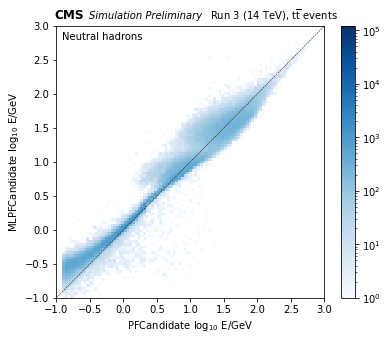

In [36]:
plot_particle_regression(ivar="energy", icls=2, particle_label="Neutral hadrons")
plt.xlabel("PFCandidate $\log_{10}$ E/GeV")
plt.ylabel("MLPFCandidate $\log_{10}$ E/GeV")
plt.savefig("energy_corr_cls2.pdf", bbox_inches="tight")

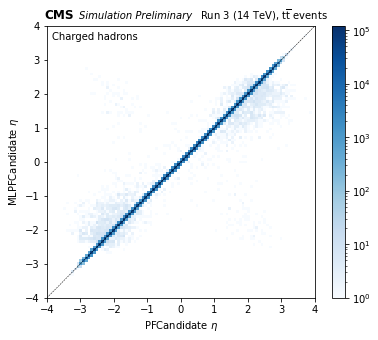

In [37]:
plot_particle_regression(ivar="eta", icls=1, particle_label="Charged hadrons", log=False, minval=-4, maxval=4)
plt.xlabel("PFCandidate $\eta$")
plt.ylabel("MLPFCandidate $\eta$")
plt.savefig("eta_corr_cls1.pdf", bbox_inches="tight")

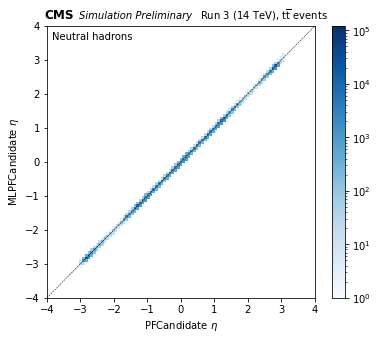

In [38]:
plot_particle_regression(ivar="eta", icls=2, particle_label="Neutral hadrons", log=False, minval=-4, maxval=4)
plt.xlabel("PFCandidate $\eta$")
plt.ylabel("MLPFCandidate $\eta$")
plt.savefig("eta_corr_cls2.pdf", bbox_inches="tight")

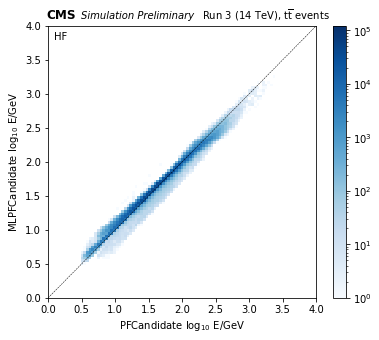

In [39]:
plot_particle_regression(ivar="energy", icls=3, particle_label="HF", minval=0.0, maxval=4)
plt.xlabel("PFCandidate $\log_{10}$ E/GeV")
plt.ylabel("MLPFCandidate $\log_{10}$ E/GeV")
plt.savefig("energy_corr_cls3.pdf", bbox_inches="tight")

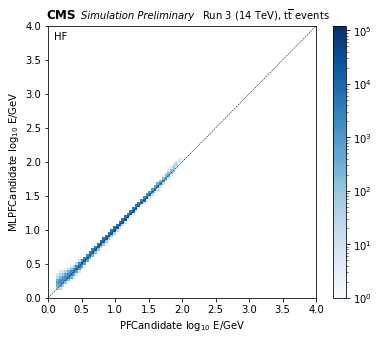

In [40]:
plot_particle_regression(ivar="energy", icls=4, particle_label="HF", minval=0.0, maxval=4)
plt.xlabel("PFCandidate $\log_{10}$ E/GeV")
plt.ylabel("MLPFCandidate $\log_{10}$ E/GeV")
plt.savefig("energy_corr_cls4.pdf", bbox_inches="tight")